In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

from prepare_dataset import prepare_dataset
import matplotlib.pyplot as plt
import uproot4 as R


/opt/local/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
train_dir = '/Users/vinaykrishnan/Documents/invmass_ml/zprime/Train/samples/train_samples/'
test_dir  = '/Users/vinaykrishnan/Documents/invmass_ml/zprime/Train/samples/test_samples/'

In [55]:
TrainDataset = pd.read_csv(train_dir+'train.csv',index_col=False)
TestDataset  = pd.read_csv(test_dir+'test_4500.csv',index_col=False)

In [56]:
df = prepare_dataset(TrainDataset,TestDataset)
#SvFitMass = df.m_sv
xtrain,x_val,ytrain,y_val = df.prepareTrain()
xtest,ytest = df.prepareTest()

In [36]:
xtest.shape

(501, 20)

In [69]:
def plot_loss(history):
    fig1,ax1 = plt.subplots()
    ax1.plot(history.history['loss'],color='g', label='loss on training samples',marker='o',markersize=10)
    ax1.plot(history.history['val_loss'], color='r',label='loss on validation samples',marker='x')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_ylim(0.07,0.5 )
    ax1.set_yscale('log')
    ax1.grid(True)
    fig1.savefig('../plots/train_dnn_zprime_new_4k_logy.png')
    # a= history.history['loss']
    # b= history.history['val_loss']
    # df = pd.DataFrame({"loss" : a, "vall_loss" : b})
    # df.to_csv('../plots/'+ args.train_m+'.csv', index=False)
def peak_position_loss(y_true, y_pred):
    peak_distance = tf.abs(y_true - y_pred)
    base_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    scaling_factor = tf.math.exp(-peak_distance)
    loss = scaling_factor * base_loss
    
    return loss
#lr for goodmodel_ep3k.h5 is 1e-4
def build_model(layer_geom,learning_rate=1e-5,input_shapes=[20]):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=input_shapes))
    for layer in layer_geom:
        model.add(tf.keras.layers.Dense(layer_geom[layer],activation='relu'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
        # model.add(tf.keras.layers.BatchNormalization())
        # if layer == 'hlayer2':
        model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Dense(1,activation='linear'))
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
    model.compile(loss='mean_absolute_error',optimizer=opt)
    return model

In [61]:
hlayer_outline = {'hlayer1':64,'hlayer2':128,'hlayer3':128,'hlayer4':64}
#hlayer_outline = {'hlayer1':32,'hlayer2':128,'hlayer3':64}
#hlayer_outline = {'hlayer1':32,'hlayer2':64,'hlayer3':64}

model = build_model(hlayer_outline,input_shapes=[20])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [62]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=50,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("../models/model_for_lossplot.h5",save_best_only=True)
history = model.fit(xtrain,ytrain, epochs=4000,batch_size =1024,validation_data=(x_val,y_val),callbacks=[checkpoint_cb])#,early_stopping_cb])


Epoch 1/4000
87/87 [==============================] - 2s 14ms/step - loss: 0.3279 - val_loss: 0.3000
Epoch 2/4000
21/87 [======>.......................] - ETA: 0s - loss: 0.2828

/Users/vinaykrishnan/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


87/87 [==============================] - 1s 7ms/step - loss: 0.2664 - val_loss: 0.2513
Epoch 3/4000
87/87 [==============================] - 1s 7ms/step - loss: 0.2420 - val_loss: 0.2309
Epoch 4/4000
87/87 [==============================] - 1s 7ms/step - loss: 0.2318 - val_loss: 0.2193
Epoch 5/4000
87/87 [==============================] - 1s 7ms/step - loss: 0.2244 - val_loss: 0.2101
Epoch 6/4000
87/87 [==============================] - 1s 8ms/step - loss: 0.2173 - val_loss: 0.2018
Epoch 7/4000
87/87 [==============================] - 1s 8ms/step - loss: 0.2104 - val_loss: 0.1939
Epoch 8/4000
87/87 [==============================] - 1s 7ms/step - loss: 0.2051 - val_loss: 0.1868
Epoch 9/4000
87/87 [==============================] - 1s 9ms/step - loss: 0.1988 - val_loss: 0.1801
Epoch 10/4000
87/87 [==============================] - 1s 9ms/step - loss: 0.1942 - val_loss: 0.1738
Epoch 11/4000
87/87 [==============================] - 1s 8ms/step - loss: 0.1902 - val_loss: 0.1682
Epoch 12/40

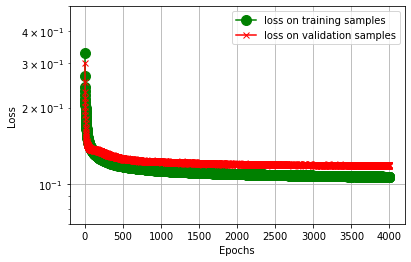

In [70]:
plot_loss(history)

16/16 [==============================] - 0s 702us/step


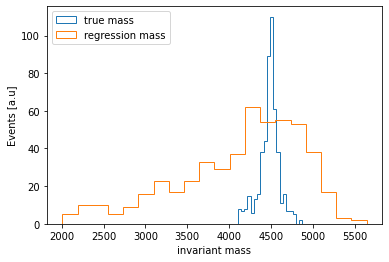

In [57]:
#model_new = tf.keras.models.load_model('../models/goodmodel_ep3k.h5')#, custom_objects={'peak_position_loss': peak_position_loss})
model_new = tf.keras.models.load_model('../models/model_with_linear.h5')#, custom_objects={'peak_position_loss': peak_position_loss})

y_pred_tr = model_new.predict(xtest)
y_pred = df.num_pipeline.inverse_transform(y_pred_tr.reshape(-1,1))
#y_pred = [i[0] for i in y_pred if i < 1020]
fig2,ax2 = plt.subplots()
ax2.hist(df.num_pipeline.inverse_transform(ytest),bins=20,label="true mass",histtype='step')
ax2.hist(y_pred,bins=20,label="regression mass",histtype='step')
#ax2.hist(SvFitMass,bins=40,label='SvFit mass',histtype='step')
ax2.set_xlabel('invariant mass')
ax2.set_ylabel('Events [a.u]')
#ax2.set_xlim((0,200))
#print(y_pred)
plt.legend()
plt.show()

In [58]:
ytrue = df.num_pipeline.inverse_transform(ytest)
tau1_pt = df.L1pT
tau2_pt = df.L2pT
tau1_eta = df.L1Eta
tau2_eta = df.L2Eta
met = df.mET

In [12]:
with R.recreate("./ZprimeM3000ToTauTau.root") as f:
        t = f.mktree("analysisTree", {"m_sv": np.float64, "dnn_mass": np.float64, "boson_mass": np.float64,"gentau1_vis_pt": np.float64,"gentau2_vis_pt":np.float64,"gentau1_vis_eta": np.float64,"gentau2_vis_eta":np.float64,"genmet":np.float64})
        t.extend({"m_sv": SvFitMass,"dnn_mass":y_pred.ravel(),"boson_mass":ytrue.ravel(),"gentau1_vis_pt":tau1_pt,"gentau2_vis_pt":tau2_pt,"gentau1_vis_eta":tau1_eta,"gentau2_vis_eta":tau2_eta,"genmet":met})

In [59]:
with R.recreate("./ZprimeM4500ToTauTau.root") as f:
        t = f.mktree("analysisTree", { "dnn_mass": np.float64, "boson_mass": np.float64,"gentau1_vis_pt": np.float64,"gentau2_vis_pt":np.float64,"gentau1_vis_eta": np.float64,"gentau2_vis_eta":np.float64,"genmet":np.float64})
        t.extend({"dnn_mass":y_pred.ravel(),"boson_mass":ytrue.ravel(),"gentau1_vis_pt":tau1_pt,"gentau2_vis_pt":tau2_pt,"gentau1_vis_eta":tau1_eta,"gentau2_vis_eta":tau2_eta,"genmet":met})

In [36]:
1.22*10000/60

203.33333333333334

In [37]:
203-180

23